In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
print(tf.__version__)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

2.12.0


In [3]:
import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info = True, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEV3IF7/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEV3IF7/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteEV3IF7/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = [] 
testing_labels = []


for s,l in train_data: 
  training_sentences.append(str(s.numpy())) 
  training_labels.append(l.numpy())

for s,l in test_data:
  testing_sentences.append(str(s.numpy())) 
  testing_labels.append(l.numpy())

training_labels_final = np.array(training_labels) 
testing_labels_final = np.array(testing_labels)

In [5]:
vocab_size = 10000
embedding_dim = 16 
max_length = 120 
trunc_type = 'post'

oov_tok= "<OOV>"

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer =  Tokenizer(num_words = vocab_size, oov_token=oov_tok) 
tokenizer.fit_on_texts(training_sentences) 
word_index = tokenizer.word_index 
sequences = tokenizer.texts_to_sequences(training_sentences) 
padded = pad_sequences(sequences,maxlen = max_length, truncating = trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences) 
testing_padded = pad_sequences(testing_sequences,maxlen = max_length)

In [6]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[0])) 
print(training_sentences[0])

? ? b this was an absolutely terrible movie don't be <OOV> in by christopher walken or michael <OOV> both are great actors but this must simply be their worst role in history even their great acting could not redeem this movie's ridiculous storyline this movie is an early nineties us propaganda piece the most pathetic scenes were those when the <OOV> rebels were making their cases for <OOV> maria <OOV> <OOV> appeared phony and her pseudo love affair with walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning i am disappointed that there are movies like this ruining <OOV> like christopher <OOV> good name i could barely sit through it
b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pa

In [7]:
model = tf.keras.Sequential([

    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(6, activation='relu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense (1, activation='sigmoid')
])

model.compile(loss="binary_crossentropy", optimizer ='adam',metrics=['accuracy'])
              
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 flatten (Flatten)           (None, 1920)              0         
                                                                 
 dense (Dense)               (None, 6)                 11526     
                                                                 
 dropout (Dropout)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 171,533
Trainable params: 171,533
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Get the embedding layer
embedding_layer = model.layers[0]

# Get the embedding layer's weights
embedding_weights = embedding_layer.get_weights()[0]
print(embedding_weights[:5])

[[-0.04015353  0.04825267 -0.01015697  0.0177047  -0.02255946 -0.04887737
  -0.03727895  0.02530464  0.03745841  0.01614969 -0.03991065  0.02801478
   0.02606685 -0.02327818  0.0307811  -0.04464941]
 [ 0.02852026  0.04952843 -0.01205247 -0.04540167 -0.00717614  0.00968057
   0.04554974  0.03039953  0.03204421  0.00247487  0.04553541 -0.01957803
   0.01807935  0.03238421  0.03805057 -0.02583265]
 [-0.0120257  -0.01895517 -0.01414856  0.02666343  0.02591963 -0.00749998
   0.02584341 -0.03239068  0.04087928 -0.03621018  0.0027025  -0.01675712
   0.03634772 -0.02685006 -0.00070462 -0.0485796 ]
 [-0.01096098 -0.02939501  0.04866226  0.01103108  0.03540245  0.04695653
  -0.04014652  0.00472844 -0.04355305 -0.04014845  0.02262494  0.04226719
   0.01967725 -0.03226249  0.0339804   0.03637988]
 [-0.01269905  0.04806249 -0.02940035 -0.03070065 -0.00901619  0.01362721
   0.04963693 -0.01418819 -0.04920289  0.04420252 -0.04393109  0.00597326
   0.02027302 -0.0060846   0.03983574 -0.02194924]]


In [9]:
num_epochs = 10
history = model.fit(padded, training_labels_final , epochs = num_epochs, validation_data = (testing_padded, testing_labels_final))

Epoch 1/10
782/782 [==============================] - 47s 53ms/step - loss: 0.5243 - accuracy: 0.7202 - val_loss: 0.3515 - val_accuracy: 0.8517
Epoch 2/10
782/782 [==============================] - 8s 11ms/step - loss: 0.2871 - accuracy: 0.8896 - val_loss: 0.3547 - val_accuracy: 0.8430
Epoch 3/10
782/782 [==============================] - 9s 11ms/step - loss: 0.1544 - accuracy: 0.9520 - val_loss: 0.4231 - val_accuracy: 0.8326
Epoch 4/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0656 - accuracy: 0.9856 - val_loss: 0.5190 - val_accuracy: 0.8246
Epoch 5/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0313 - accuracy: 0.9955 - val_loss: 0.6191 - val_accuracy: 0.8257
Epoch 6/10
782/782 [==============================] - 7s 9ms/step - loss: 0.0181 - accuracy: 0.9981 - val_loss: 0.7185 - val_accuracy: 0.8263
Epoch 7/10
782/782 [==============================] - 6s 8ms/step - loss: 0.0128 - accuracy: 0.9988 - val_loss: 0.7818 - val_accuracy: 0.8284
Ep

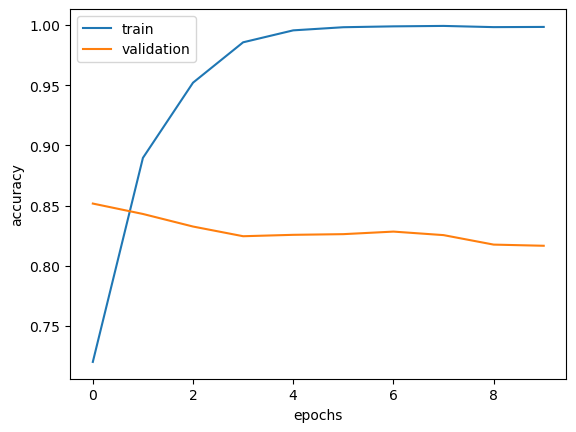

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train','validation'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()

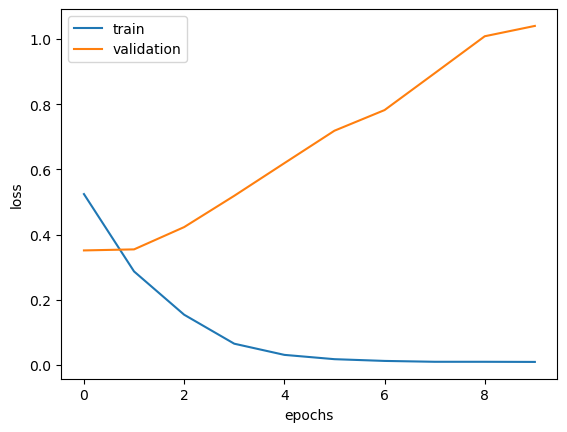

In [11]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights)

[[-0.00887826  0.02132905 -0.01448485 ... -0.02226633  0.01205
  -0.04429727]
 [ 0.05279347  0.05934654  0.0084999  ...  0.03328948  0.02399037
  -0.0346385 ]
 [ 0.05136138 -0.02224219 -0.00434881 ...  0.00105555  0.02173099
  -0.02118235]
 ...
 [ 0.02098473 -0.02046013  0.02106685 ...  0.00909061  0.0347597
   0.04603104]
 [-0.11437756  0.07854278 -0.09027288 ... -0.01712344 -0.07642192
   0.02241017]
 [-0.08256155  0.03826455 -0.09058253 ... -0.03016462 -0.12597752
  -0.05690184]]


In [13]:
import io
out_v = io.open('vecs.tsv','w',encoding = 'utf-8')
out_m = io.open('meta.tsv','w',encoding = 'utf-8')
for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + '\n')
out_v.close()
out_m.close()